In [1]:
import pandas as pd
import numpy as np
from time import time
from config_loader import load
import argparse
import sys
import seaborn as sns
from MyDataUnderstanding import featureAnalysis
from MyPreprocessing import MyPreprocessing
import numpy as np
from time import time
import matplotlib.pyplot as plt
from model.models import models_perform
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from statistics import mean
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from detect_outliers import detect_outliers

In [2]:
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.svm import SVC
from xgboost import XGBClassifier as XGB
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from model.MyIBL import MyIBL as IBL
from sklearn.linear_model import LogisticRegression as LG

In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 500)

In [4]:
def getData(path, filenames_type):
    '''
    features_lst = [
        "Pclass", "Survived", "Name", "Sex", "Age",
        "Sibsp", "Parch", "Ticket", "Fare", "Cabin","Embarked",
        "Boat","Body","Home.dest"]
    '''
    if filenames_type == 'train':
        filename = 'train'
    elif filenames_type == 'test':
        filename = 'test'
    else:
        filename = 'titanicAll'
        
    df_features = pd.read_csv(path + filename + '.csv',
                           sep=',')

    if filename_type not in ['train', 'test']:
        # drop unnecessary columns that don't exist in the official data
        df_features.drop(['Boat', 'Body', 'Home.dest'],
                           axis=1,
                           inplace=True)
    #labels = df_features['Survived']
    #df_features = df_features.drop(['Survived'], axis=1)
    return df_features

In [5]:
parser = argparse.ArgumentParser()
parser.add_argument(
    "-c", "--config", default="titanic.cfg",
    help="specify the location of the clustering config file"
)
args, _ = parser.parse_known_args()

config_file = args.config
config = load(config_file)

##
verbose = config.get('titanic', 'verbose')
path = config.get('titanic', 'path') + '/'
file_type = config.get('titanic', 'file_type')

In [6]:
print(file_type)
filename_type = 'train'
if file_type == 'all':
    filename_type = 'other'

trainData = getData(path, filename_type)

# Preprocessing
trainPreprocess = MyPreprocessing(filename_type)

## test
filename_type = 'test'
testData = getData(path, filename_type)
# Preprocessing
testPreprocess = MyPreprocessing(filename_type)

traintest


In [7]:
trainPreprocess.fit(trainData)
df_train = trainPreprocess.new_df
# the labels "Survived"
labels = trainPreprocess.labels_

testPreprocess.fit(testData)
df_test = testPreprocess.new_df
labels_test = testPreprocess.labels_

# fix missing columns because of NaNs and one hot encoding without dummy_na
if df_train.shape[1] != df_test.shape[1]:
    missing_cols = set(df_test.columns) - set(df_train.columns)
    for col in missing_cols:
        #df_train[col] = np.zeros([df_train.shape[0], 1])
        df_test.drop([col], axis=1, inplace=True)

    missing_cols = set(df_train.columns) - set(df_test.columns)
    for col in missing_cols:
        #df_test[col] = np.zeros([df_test.shape[0], 1])
        df_train.drop([col], axis=1, inplace=True)

In [8]:
print(df_train.shape) == print(df_test.shape)

(891, 48)
(418, 48)


True

In [9]:
def feature_importance(clf, df_train):
    if hasattr(clf, 'feature_importances_'):
        name = str(clf.__class__).split('.')[-1][:-2]
        feat_imp = pd.DataFrame({'importance':clf.feature_importances_})    
        feat_imp['feature'] = df_train.columns
        feat_imp.sort_values(by='importance', ascending=False, inplace=True)
        #feat_imp = feat_imp.iloc[:top_n]
        feat_imp.sort_values(by='importance', inplace=True)
        feat_imp = feat_imp.set_index('feature', drop=True)
        feat_imp.plot.barh(title='Feature Importance', figsize=(10,10))
        plt.xlabel('%s Feature Importance Score' %name)
        plt.show()
        return feat_imp
    return pd.DataFrame()

In [10]:
def ensemble(clf, x_train, y_train, x_test):
    
    name = str(clf.__class__).split('.')[-1][:-2]
    kf = KFold(n_splits=5)

    ntrain = x_train.shape[0]
    ntest = x_test.shape[0]

    #ens_train = np.zeros((ntrain,))
    ens_train = np.array([])
    #ens_test = np.zeros((ntest,))
    #test_kf = np.empty((kf.n_folds, ntest))
    test_kf = np.zeros((kf.n_splits, ntest))
        
    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train.loc[train_index]
        y_tr = y_train.loc[train_index]
        x_te = x_train.loc[test_index]

        clf.fit(x_tr, y_tr)

        #ens_train[test_index] = clf.predict(x_te)
        ens_train = np.concatenate([ens_train, clf.predict(x_te)])
        # predict from the whole train set 
        #clf.fit(x_train,y_train)
        test_kf[i, :] = clf.predict(x_test)
    
    # features for next ensemble layer
    ens_train = pd.DataFrame(ens_train.reshape(-1,1), columns=[name])
    
    # combine for test
    ens_test = pd.DataFrame(test_kf.T).mode(axis=1)
    ens_test.columns = [name]
    
    return ens_train, ens_test

In [11]:
def modeler(clf, data, labels, train_fidx, validation_fidx):
    name = str(clf.__class__).split('.')[-1][:-2]
    print(name)
    folds_accuracy = list()
    duration = list()
    start = time()
    for idx, trf in enumerate(train_fidx):
        clf.fit(data.loc[trf], labels.loc[trf])
        prediction_labels = clf.predict(data.loc[validation_fidx[idx]])
        folds_accuracy.append(accuracy_score(labels.loc[validation_fidx[idx]], prediction_labels))
        
    mean_acc = mean(folds_accuracy)
    duration = time() - start
    print(name, mean_acc, "accuracy at validation stage,", duration, 's')
    df_folds_accuracy = pd.DataFrame([folds_accuracy], index=[name])
    df_folds = pd.DataFrame([[mean_acc, duration/len(train_fidx)]], columns=['Accuracy', 'Duration'], index=[name])
    return clf.fit(data, labels), df_folds, df_folds_accuracy

In [12]:
def get_cv_data(df_train, cv=5):
    kf = KFold(n_splits=cv)
    folds = [(train_idx, validation_idx) for train_idx, validation_idx in kf.split(df_train)]
    train_idx = [f[0] for f in folds]
    validation_idx = [f[1] for f in folds]
    return train_idx, validation_idx

In [13]:
def run_models(clfs, df_train, df_test, train_idx, validation_idx, cv=True, ens=True):
    models = []
    df_ens_features = pd.DataFrame()
    df_ens_test = pd.DataFrame()
    df_model_cvaccuracies = pd.DataFrame()
    df_model_info = pd.DataFrame()
    for clf in clfs:
        name = str(clf.__class__).split('.')[-1][:-2]
        
        # cross validation
        if cv:
            model, df_folds, df_folds_accuracy = modeler(clf, df_train, labels, train_idx, validation_idx)
            models.append(model)
            df_model_cvaccuracies = pd.concat([df_model_cvaccuracies, df_folds_accuracy], sort=False)
            df_model_info = pd.concat([df_model_info, df_folds], sort=False)  
            
            feature_importance(clf, df_train)
        
        # building ensemble
        if cv and ens:
            #df_feature = pd.DataFrame(cross_val_predict(clf, df_train, labels, cv=ens_kf).reshape(-1,1), columns=[name])
            df_ens_feature, ens_test = ensemble(clf, df_train, labels, df_test)
            df_ens_features = pd.concat([df_ens_features, df_ens_feature], axis=1, sort=False).reset_index(drop=True)
            df_ens_test = pd.concat([df_ens_test, ens_test], axis=1, sort=False).reset_index(drop=True)
            
    return models, df_model_cvaccuracies, df_model_info, df_ens_features, df_ens_test
        

In [14]:
def correlation_fig(df_ens_features):
    # calculate the correlation matrix
    corr = df_ens_features.corr()

    # plot the heatmap
    sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns)

In [15]:
clfs = [IBL(), RF(n_estimators =12), SVC(gamma='scale'), XGB(), MLP(max_iter=1000), KNN(), LDA()]
#clfs = [RF(n_estimators =12), SVC(gamma='scale'), XGB(), KNN(), LDA()]

In [16]:
train_idx, validation_idx = get_cv_data(df_train, cv=5)

MyIBL
MyIBL 0.7138158307701965 accuracy at validation stage, 7.131070613861084 s
RandomForestClassifier
RandomForestClassifier 0.7912685958194715 accuracy at validation stage, 0.09807062149047852 s


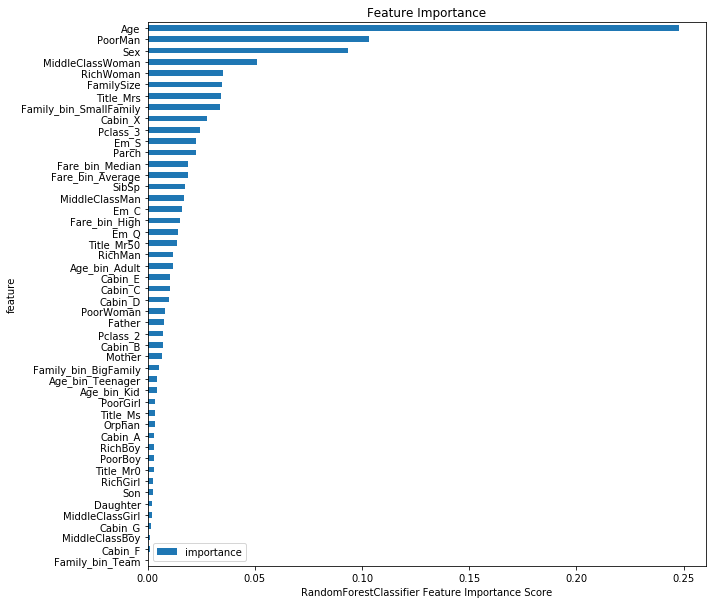

SVC
SVC 0.8316427091833533 accuracy at validation stage, 0.15913057327270508 s
XGBClassifier
XGBClassifier 0.8383905592869249 accuracy at validation stage, 0.9076433181762695 s


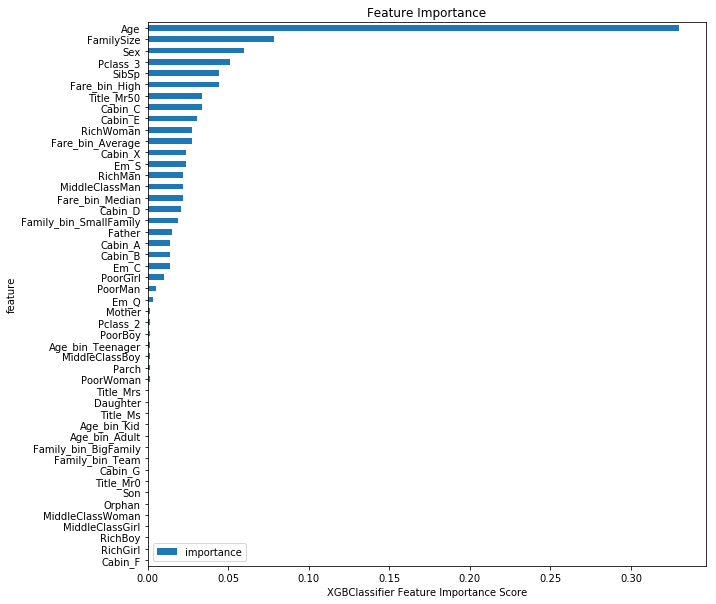

MLPClassifier
MLPClassifier 0.8237963718536188 accuracy at validation stage, 17.949856519699097 s
KNeighborsClassifier
KNeighborsClassifier 0.824938798568828 accuracy at validation stage, 0.08806371688842773 s
LinearDiscriminantAnalysis
LinearDiscriminantAnalysis 0.817048521750047 accuracy at validation stage, 0.115081787109375 s


c:\users\jim\appdata\local\programs\python\python36\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
c:\users\jim\appdata\local\programs\python\python36\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
c:\users\jim\appdata\local\programs\python\python36\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
c:\users\jim\appdata\local\programs\python\python36\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
c:\users\jim\appdata\local\programs\python\python36\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
c:\users\jim\appdata\local\programs\python\python3

In [54]:
models, df_model_cvaccuracies, df_model_info, df_ens_features, df_ens_test = run_models(clfs, df_train, df_test, train_idx, validation_idx, cv=True, ens=True)

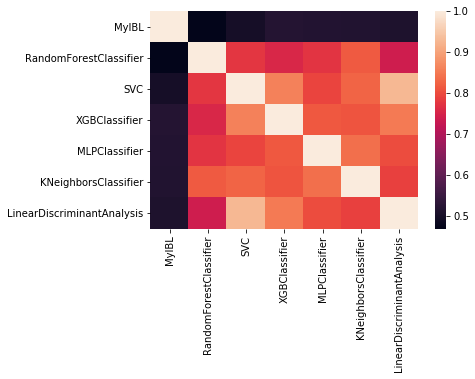

In [56]:
correlation_fig(df_ens_features)

In [57]:
df_ens_features.columns, df_ens_features.shape

(Index(['MyIBL', 'RandomForestClassifier', 'SVC', 'XGBClassifier', 'MLPClassifier', 'KNeighborsClassifier', 'LinearDiscriminantAnalysis'], dtype='object'),
 (891, 7))

In [58]:
df_ens_test.columns, df_ens_test.shape

(Index(['MyIBL', 'RandomForestClassifier', 'SVC', 'XGBClassifier', 'MLPClassifier', 'KNeighborsClassifier', 'LinearDiscriminantAnalysis'], dtype='object'),
 (418, 7))

In [61]:
df_ens = df_ens_features[['MyIBL','SVC']]
df_new_test = df_ens_test[['MyIBL', 'SVC']]

In [67]:
xgb = XGB()
xgb.fit(df_ens, labels)
xgb.score(df_new_test, labels_test)

0.7822966507177034

In [68]:
for model in models:
    name = str(model.__class__).split('.')[-1][:-2]
    print(name, accuracy_score(labels_test, model.predict(df_test)))

MyIBL 0.6626794258373205
RandomForestClassifier 0.7583732057416268
SVC 0.784688995215311
XGBClassifier 0.7583732057416268
MLPClassifier 0.7655502392344498
KNeighborsClassifier 0.7631578947368421
LinearDiscriminantAnalysis 0.7559808612440191


In [17]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(df_train, labels)
#model = SelectFromModel(lsvc, prefit=True)
model = SelectFromModel(RF(n_estimators=100, random_state=101), threshold='median')
model.fit(df_train, labels)
train_new = model.transform(df_train)
feature_idx = model.get_support()
df_train_fs = pd.DataFrame(train_new, columns=df_train.columns[feature_idx])
test_new = model.transform(df_test)
df_test_fs = pd.DataFrame(test_new, columns=df_test.columns[feature_idx])
df_test_fs.shape

(418, 24)

In [18]:
clfs = [IBL(), RF(n_estimators =12), SVC(gamma='scale'), XGB(), MLP(max_iter=10000), KNN(), LDA()]

MyIBL
MyIBL 0.7407695687653003 accuracy at validation stage, 7.530353307723999 s
RandomForestClassifier
RandomForestClassifier 0.7912748728893353 accuracy at validation stage, 0.09108424186706543 s


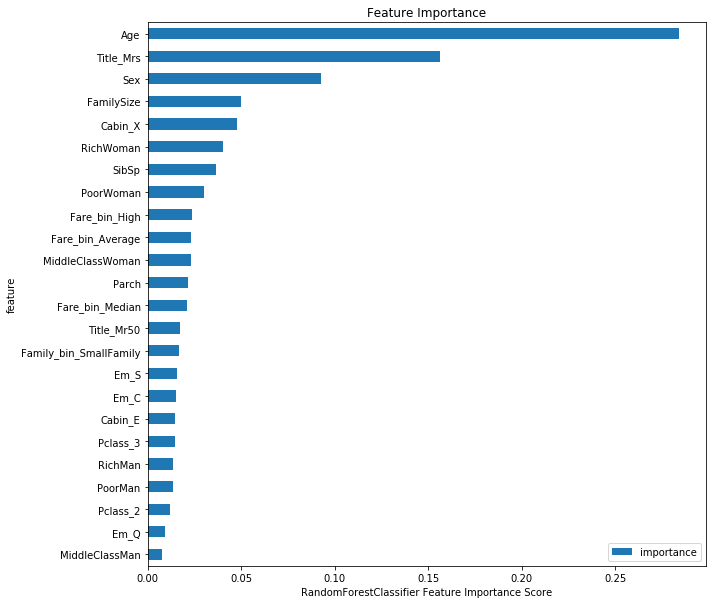

SVC
SVC 0.8260184545853996 accuracy at validation stage, 0.10007262229919434 s
XGBClassifier
XGBClassifier 0.8451195781809051 accuracy at validation stage, 0.5473892688751221 s


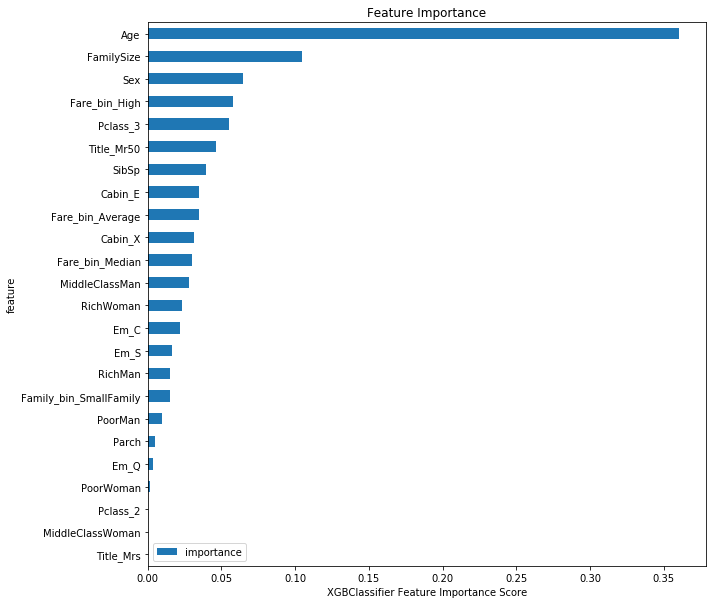

MLPClassifier
MLPClassifier 0.8170799070993661 accuracy at validation stage, 20.308966636657715 s
KNeighborsClassifier
KNeighborsClassifier 0.817111292448685 accuracy at validation stage, 0.041028499603271484 s
LinearDiscriminantAnalysis
LinearDiscriminantAnalysis 0.8249325214989642 accuracy at validation stage, 0.06304335594177246 s


c:\users\jim\appdata\local\programs\python\python36\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
c:\users\jim\appdata\local\programs\python\python36\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
c:\users\jim\appdata\local\programs\python\python36\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
c:\users\jim\appdata\local\programs\python\python36\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
c:\users\jim\appdata\local\programs\python\python36\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
c:\users\jim\appdata\local\programs\python\python3

In [19]:
models, df_model_cvaccuracies, df_model_info, df_ens_features, df_ens_test = run_models(clfs, df_train_fs, df_test_fs, train_idx, validation_idx, cv=True, ens=True)

In [21]:
for model in models:
    name = str(model.__class__).split('.')[-1][:-2]
    print(name, accuracy_score(labels_test, model.predict(df_test_fs)))

MyIBL 0.722488038277512
RandomForestClassifier 0.7631578947368421
SVC 0.7799043062200957
XGBClassifier 0.7655502392344498
MLPClassifier 0.777511961722488
KNeighborsClassifier 0.7655502392344498
LinearDiscriminantAnalysis 0.777511961722488


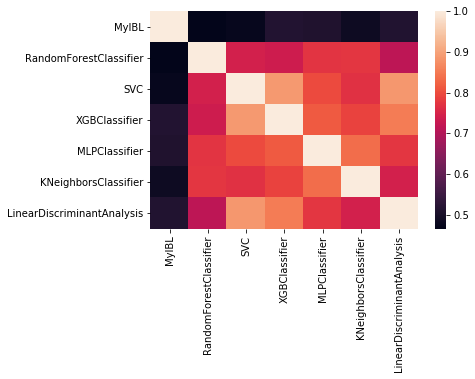

In [22]:
correlation_fig(df_ens_features)

In [23]:
df_ens_features.columns

Index(['MyIBL', 'RandomForestClassifier', 'SVC', 'XGBClassifier', 'MLPClassifier', 'KNeighborsClassifier', 'LinearDiscriminantAnalysis'], dtype='object')

In [24]:
df_ens = df_ens_features[['MyIBL', 'SVC']]
df_new_test = df_ens_test[['MyIBL', 'SVC']]

In [25]:
xgb = XGB()
xgb.fit(df_ens, labels)
xgb.score(df_new_test, labels_test)

0.7822966507177034

In [26]:
df_model_info

,Accuracy,Duration
MyIBL,0.740770,1.506071
RandomForestClassifier,0.791275,0.018217
SVC,0.826018,0.020015
XGBClassifier,0.845120,0.109478
MLPClassifier,0.817080,4.061793
KNeighborsClassifier,0.817111,0.008206
LinearDiscriminantAnalysis,0.824933,0.012609


In [27]:
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
accum_acc_lst = df_model_cvaccuracies.values

print("Friedman test on 'accuracy'")
stat, p = friedmanchisquare(*accum_acc_lst)
print(stat, p)

Friedman test on 'accuracy'
21.808118081180815 0.0013117209584246083


c:\users\jim\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


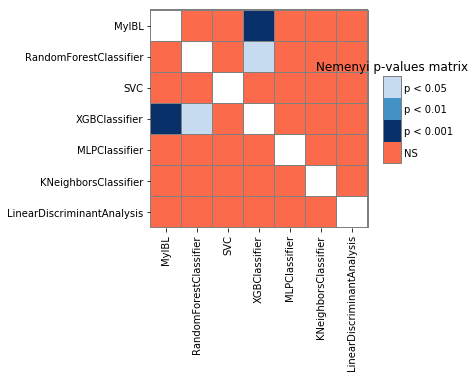

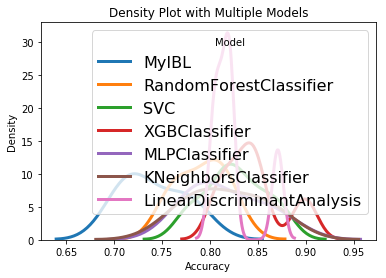

In [28]:
a = 0.05
if p < a:
    row_names = df_model_cvaccuracies.index.tolist()

    res = sp.posthoc_nemenyi_friedman(accum_acc_lst.T)
    res = res.rename(columns={i:row_names[i] for i in res.columns},
                     index={i:row_names[i] for i in res.columns})
    plt.figure(1)
    cmap = ['1', '#fb6a4a',  '#08306b',  '#4292c6', '#c6dbef']
    heatmap_args = {'cmap': cmap, 'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
    sp.sign_plot(res, **heatmap_args)
    plt.title('Nemenyi p-values matrix')

    plt.figure(2)
    for acc, row in zip(accum_acc_lst, row_names):
        # Subset to the airline

        # Draw the density plot
        sns.distplot(acc, hist = False, kde = True,
                    kde_kws = {'linewidth': 3},
                    label = row)

    # Plot formatting
    plt.legend(prop={'size': 16}, title = 'Model')
    plt.title('Density Plot with Multiple Models')
    plt.xlabel('Accuracy')
    plt.ylabel('Density')

plt.show()

In [34]:
df_train_fs.shape

(891, 24)

In [52]:
from detect_outliers import detect_outliers
Outliers_to_drop = detect_outliers(trainData,2,["Age","SibSp","Parch","Pclass"])

In [54]:
len(Outliers_to_drop) # these can be removed

7